# **CONVOLUTIONAL NEURAL NETWORK (CNN)**

## Problem

Train a CNN on the [Cats-vs-Dogs dataset]().

Note: Dataset is not divided into train-vaidation-test. Needs a lot of pre-processing.

## Initialize

In [1]:
import cv2
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt

In [2]:
# set random seeds
np.random.seed(0)
tf.random.set_seed(0)

# show figures inline
%matplotlib inline

# ignore all warning (NOT recommended)
warnings.filterwarnings("ignore")

## Dataset

Get the datase using [this jupyter notebook](01a-Cat-Dog-Dataset-Preparation.ipynb).

**Dataset directories**

In [3]:
# root directory
ROO_DIR = '../.tmp/cats-and-dogs'

# directory for the subsets
DIR_TRAIN = ROO_DIR + '/train'
DIR_VALID = ROO_DIR + '/valid'
DIR_TEST = ROO_DIR + '/test'

# directory for log
DIR_LOG = '01-logs'

## Data Augmentation

[See tensorflow docs](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

**Note**
- We perform augmentation only for the training images.
- We normalize all training, validation, and testing images.
- We do not need to shuffle the validation and testing images.

In [4]:
INPUT_SIZE = (150, 150, 3)
BATCH_SIZE = 64

# generate image data with normalization and augmentation
train_datagen = ImageDataGenerator(
    rescale=1 / 255.,
    rotation_range=5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.8, 1.2),
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
)

# train data generator
train_generator = train_datagen.flow_from_directory(
    directory=DIR_TRAIN,
    target_size=INPUT_SIZE[:2],
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=0
)

# generate image data only with normalization
test_datagen = ImageDataGenerator(
    rescale=1 / 255.,
)

# validation data generator
valid_generator = test_datagen.flow_from_directory(
    directory=DIR_TEST,
    target_size=INPUT_SIZE[:2],
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# test data generator
test_generator = test_datagen.flow_from_directory(
    directory=DIR_TEST,
    target_size=INPUT_SIZE[:2],
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 19998 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


#### Check one image

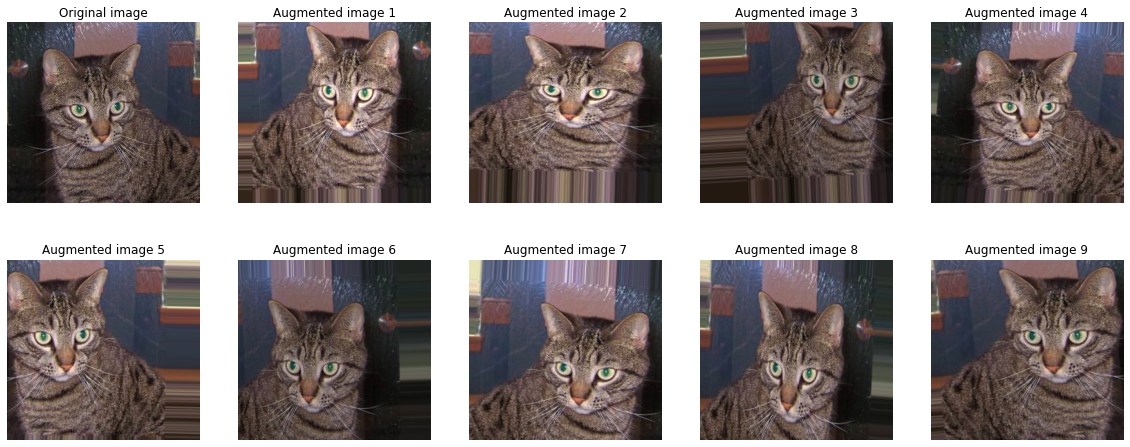

In [5]:
# get one image
img = cv2.imread(f'{DIR_TRAIN}/cat/1.jpg')
# convert BGR to RGB
img = img[:, :, ::-1]

# show the original image
plt.figure(figsize=(20, 8))
plt.subplot(2,5,1)
plt.title('Original image')
plt.axis('off')
plt.imshow(img)

# get augmented images
for i in range(9):
    # perform random augmentation
    # NOTE: it performs all random transformation defined in 'train_datagen'
    # except the rescaling
    aug_img = train_datagen.random_transform(img)

    # convert float to uint8
    aug_img = aug_img.astype('uint8')

    # plot the figures
    plt.subplot(2,5,i+2)
    plt.title(f'Augmented image {i+1}')
    plt.axis('off')
    plt.imshow(aug_img)

plt.show()

## Model

**Note**
- The problem is binary classification.
- Use `'sigmoid'` activation function in the output layer.
- Use `'binary_crossentropy'` loss.

In [6]:
# input layer
input_tensor = Input(shape=INPUT_SIZE)

# convolution layers
x = Conv2D(32, 3, activation='relu')(input_tensor)
x = MaxPool2D()(x)
x = Conv2D(64, 3, activation='relu')(x)
x = MaxPool2D()(x)
x = Conv2D(128, 3, activation='relu')(x)
x = MaxPool2D()(x)
x = Conv2D(128, 3, activation='relu')(x)
x = MaxPool2D()(x)

# fully-connected layers
x = Flatten()(x)
x = Dense(512, activation='relu')(x)

# output layer with 'sigmoid' activation function
output_tensor = Dense(1, activation='sigmoid')(x)

# model
model = tf.keras.Model(input_tensor, output_tensor)

# compile with 'binary_crossentropy' loss
model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['acc'],
)

# model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0     

## Callback

- You can use [pre-defined callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks).
- Or, you can define custom callback to have more control over what happens during the training or prediction.
[See more](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback).

**`ReduceLROnPlateau()`**
- Reduces the learning rate by a factor (defined in `factor`)
if the monitored metric (defined in`monitor`) does not improve
for a number of consecutive eporchs (defined in `patience`).

**`EarlyStopping()`**
- Stops the training if the monitored metric (defined in`monitor`)
does not improve by a defined amount (`min_delta`)
for a number of consecutive eporchs (defined in `patience`).

**`TensorBoard()`**
- Enables tensorboard visualization.
- Launce from commandline: ```tensorboard --logdir=path_to_your_logs```

In [7]:
# reduce learning rate
reduce_rl = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=3, verbose=2
)

# stop training
early_stopping = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=2
)

# visualize in tensorboard
tensorboard = TensorBoard(log_dir=DIR_LOG)

# commandline from root directory:
# tensorboard --logdir=02-Computer-Vision/01-logs

## Training

In [8]:
# train the model and save the history
hist = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs=100,
    verbose=1,
    class_weight = [1., 1.],
    callbacks=[reduce_rl, early_stopping, tensorboard]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 313 steps, validate for 40 steps
Epoch 1/100
313/313 [==============================] - 147s 469ms/step - loss: 0.6938 - acc: 0.5142 - val_loss: 0.6700 - val_acc: 0.5588
Epoch 2/100
313/313 [==============================] - 145s 464ms/step - loss: 0.6593 - acc: 0.6047 - val_loss: 0.5918 - val_acc: 0.6888
Epoch 3/100
313/313 [==============================] - 146s 466ms/step - loss: 0.5858 - acc: 0.6901 - val_loss: 0.5216 - val_acc: 0.7460
Epoch 4/100
313/313 [==============================] - 146s 465ms/step - loss: 0.5322 - acc: 0.7324 - val_loss: 0.4386 - val_acc: 0.7884
Epoch 5/100
313/313 [==============================] - 146s 465ms/step - loss: 0.4907 - acc: 0.7652 - val_loss: 0.4068 - val_acc: 0.8112
Epoch 6/100
313/313 [==============================] - 146s 467ms/step - loss: 0.4567 - acc: 0.7842 - val_loss: 0.3597 - val_acc: 0.8420
Epoch 7/100
313/313 [==============================] - 146s 466ms/step - loss: 0.4148

**Save model**

`model.save()`
- Saves entire model (architecture, weight, and state).
- To load, use `tf.keras.models.load_model()`.

`model.save_weights()`
- Saves only the weights.
- To load, build the model first. Then, `model.load_weights`.

In [9]:
# save the entire model
model.save(DIR_LOG + '/cnn_model.h5', include_optimizer=False)

## Evauation

In [10]:
# get prediction on the test images
y_pred = model.predict(test_generator)
y_pred = y_pred > 0.5

**Confusion matrix**

In [11]:
# get true test labels
y_test = test_generator.labels

# confusion matrix
conf_mat = confusion_matrix(y_test, y_pred, normalize='true')

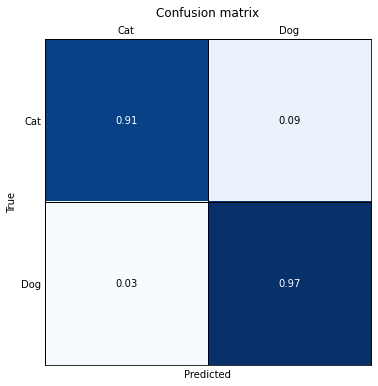

In [12]:
# get name of the classes
labels = list(test_generator.class_indices.keys())
# capitalize
labels = [l.capitalize() for l in labels]
# get indices of the classes
indices = list(test_generator.class_indices.values())

# figure for displaying the confusion matrix
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()

# display the confution matrix
cax = ax.matshow(conf_mat, cmap='Blues')

# show the values
for (i, j), z in np.ndenumerate(conf_mat):
    text_color = 'w' if i == j else 'k'
    if z < 0.005:
        continue
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', c=text_color)

# title and axis labels
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# show class names
plt.xticks(indices, labels)
plt.yticks(indices, labels)
ax.tick_params(axis='both', which='both', length=0)

# show grid lines
ax.set_xticks(np.arange(-.5, 2, 1), minor=True)
ax.set_yticks(np.arange(-.5, 2, 1), minor=True)
ax.grid(which='minor', color='k', linestyle='-', linewidth=1)

plt.show()

**Other metrics**

In [13]:
# calculate precision, recall, and f1 score
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

In [14]:
# pandas data frame for storing the metrics
df = pd.DataFrame({
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
},
    index=labels
)

# calculate the mean
df.loc['(Average)'] = df.mean()

# display
df

,Precision,Recall,F1-score
Cat,0.972603,0.9088,0.939620
Dog,0.914414,0.9744,0.943455
(Average),0.943509,0.9416,0.941537
